#PP and PS AVO modeling and generating synthetics

This notebook is a tutorial on how to use the zoeppritz equations in the agilegeo AVO Python module for creating P-wave and Sv-converted wave AVO synthetics.

We start by importing NumPy; a package for numerical computation, Matplotlib; a package for plotting and graphics; and agilgeo's AVO reflectivity functions for the full zoeppritz solution

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
% matplotlib inline

## 1. Half-space example

Let's consider a Class 1 gas sand response; where the upper layer is a shale, and the lower layer is a sand that has lower P and S impedance relative to the shale:

|  | Vp [m/s] | Vs [m/s] | Density [kg/m3] |
|-------------|----------|----------|----------|
| upper layer | 3300 | 1500 | 2400 |
| lower layer | 3050 | 1400 | 2075 |

In [3]:
# Upper layer rock properties
vp1 = 3300.0
vs1 = 1500.0
rho1 = 2400.0

# Lower layer rock properties
vp0 = 3050.0
vs0 = 1400.0
rho0 = 2075.0

# An array of angles
theta1 = np.arange(0, 60)

Select the PP and PS reflection coefficients,

In [4]:
from bruges.reflection import zoeppritz_element

Rpp = zoeppritz_element(vp1, vs1, rho1, vp0, vs0, rho0, theta1, 'PdPu')
Rps = zoeppritz_element(vp1, vs1, rho1, vp0, vs0, rho0, theta1, 'PdSu')
Rpp

array([-0.11167646, -0.11165281, -0.11158194, -0.11146404, -0.11129945,
       -0.11108866, -0.11083228, -0.11053107, -0.11018591, -0.10979784,
       -0.10936803, -0.10889779, -0.10838856, -0.10784196, -0.10725972,
       -0.10664373, -0.10599602, -0.1053188 , -0.10461439, -0.1038853 ,
       -0.1031342 , -0.1023639 , -0.1015774 , -0.10077787, -0.09996866,
       -0.0991533 , -0.0983355 , -0.09751921, -0.09670856, -0.0959079 ,
       -0.09512182, -0.09435515, -0.09361298, -0.09290068, -0.09222388,
       -0.09158857, -0.09100104, -0.09046795, -0.08999633, -0.08959366,
       -0.08926784, -0.0890273 , -0.08888096, -0.08883836, -0.08890968,
       -0.0891058 , -0.08943836, -0.08991989, -0.09056382, -0.09138466,
       -0.09239806, -0.09362096, -0.09507172, -0.09677028, -0.09873839,
       -0.10099973, -0.10358021, -0.10650821, -0.10981487, -0.11353445])

## Plot the AVO responses

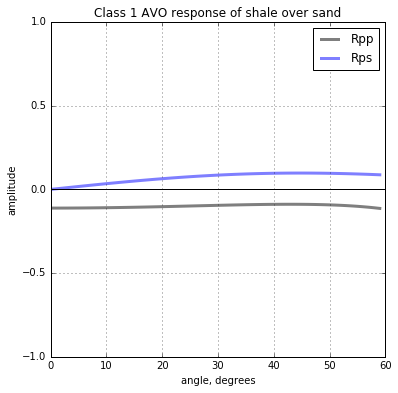

In [5]:
# make a figure
fig = plt.figure(figsize=(6, 6), facecolor='w')

# create an axis object
ax = fig.add_subplot(111)

# Plot the curves
ax.plot(theta1, Rpp, 'k', lw=3, alpha=0.5, label='Rpp')
ax.plot(theta1, Rps, 'b', lw=3, alpha=0.5, label='Rps')

# Decorate the plot
ax.set_title('Class 1 AVO response of shale over sand')
ax.legend(loc='upper right')
ax.set_xlabel('angle, degrees')
ax.set_ylabel('amplitude')
ax.set_ylim((-1, 1))
ax.grid()
ax.axhline(y=0, color='k')

plt.show()

## 2. A simple 1D example

### Make a model

Let's create a simple 4-layer model, with 3 reflection interfaces. We'll use the first two rocks from the half space example above; we'll call the the shale 'rock A' and the sand 'rock B'. Let's make the third layer a 'shaley sand' (rock C), and the bottom layer another shale (rock D).

|  | Vp (m/s) | Vs (m/s) | Density (kg/m<sup>3</sup>)
|-------------|----------|----------|
| rock A | 3300 | 1500 | 2400
| rock B | 3050 | 1400 | 2075 
| rock C | 3100 | 1500 | 2250
| rock D | 3350 | 1525 | 2450

We could add the reflectivity curves to the graph above to study the AVO behaviour, however we can create a vertical pseudo-log for Vp, Vs, and density by giving each layer a finite thickness. We can define each layer by using a dictionaries with 3 entries: Vp, Vs, and density, like so:

In [23]:
rock_a = {'vp': 3300.0, 'vs': 1500.0, 'rho': 2400.0}
rock_b = {'vp': 3050.0, 'vs': 1400.0, 'rho': 2075.0}
rock_c = {'vp': 3100.0, 'vs': 1500.0, 'rho': 2250.0}
rock_d = {'vp': 3350.0, 'vs': 1525.0, 'rho': 2450.0}

strat = [rock_a, rock_b, rock_c, rock_d]

In [24]:
vp = [rock['vp'] for rock in strat]
vs = [rock['vs'] for rock in strat]
rho = [rock['rho'] for rock in strat]

In [25]:
# Fake x values for model space
x = np.linspace(0, 1.0, 4)

# 'Real' x values for model space — this is time so call it t
# We'll make it one second long, with a 1 ms sample interval.
t = np.linspace(0, 1.0, 1000)

# Make interpolation function
import scipy.interpolate
def interp(x, y, x_new):
    f = scipy.interpolate.interp1d(x, y, kind='nearest')
    return f(x_new)

dvp, dvs, drho = [np.diff(interp(x, i, t)) for i in (vp, vs, rho)]
vp, vs, rho = [interp(x, i, t) for i in (vp, vs, rho)]

Admittedly, this isn't a very elegant way to build a 1-D model of the earth; but it gets the job done for this simple case. A future improvement to this notebook is to include a more elegant way of building a 1-D earth model using [Striplog](https://github.com/agile-geoscience/striplog).

### Compute reflectivities

We find and step through every interface in the log and append the Rpp and Rps AVO curves to a lists called <code>Rpp_z</code> and <code>Rps_z</code> respectively,

In [26]:
boundaries = np.abs(dvp) + np.abs(dvs) + np.abs(drho)  # Lazy catch-all

In [27]:
logs = zip(boundaries, vp[:-1], vs[:-1], rho[:-1], vp[1:], vs[1:], rho[1:])
Rpp, Rps = [], []
for boundary, vp1, vs1, rho1, vp0, vs0, rho0 in logs:
    if boundary:
        Rpp.append(zoeppritz_element(vp1, vs1, rho1, vp0, vs0, rho0, theta1, 'PdPu'))
        Rps.append(zoeppritz_element(vp1, vs1, rho1, vp0, vs0, rho0, theta1, 'PdSu'))
    else:
        Rpp.append(np.zeros(theta1.size))
        Rps.append(np.zeros(theta1.size))
Rpp = np.asarray(Rpp)
Rps = np.asarray(Rps)

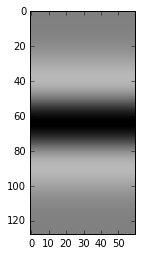

In [32]:
import bruges as b
wvlt = b.filters.ricker(duration=0.128, dt=0.001, f=15)

traces = theta1.size
w = np.tile(wvlt, traces).reshape(traces, wvlt.size).T

plt.imshow(w, cmap='gray_r', clim=[-1,1])
plt.show()

In [33]:
import bruges as b
wvlt = b.filters.ricker(duration=0.128, dt=0.001, f=15)

traces = theta1.size
w = np.tile(wvlt, traces).reshape(traces, wvlt.size).T

plt.imshow(w, cmap='gray_r', clim=[-1,1])
plt.show()
from scipy.signal import fftconvolve

syn_pp = fftconvolve(Rpp, w, mode='same')
syn_ps = fftconvolve(Rps, w, mode='same')

## Plot the well logs and synthetic gathers

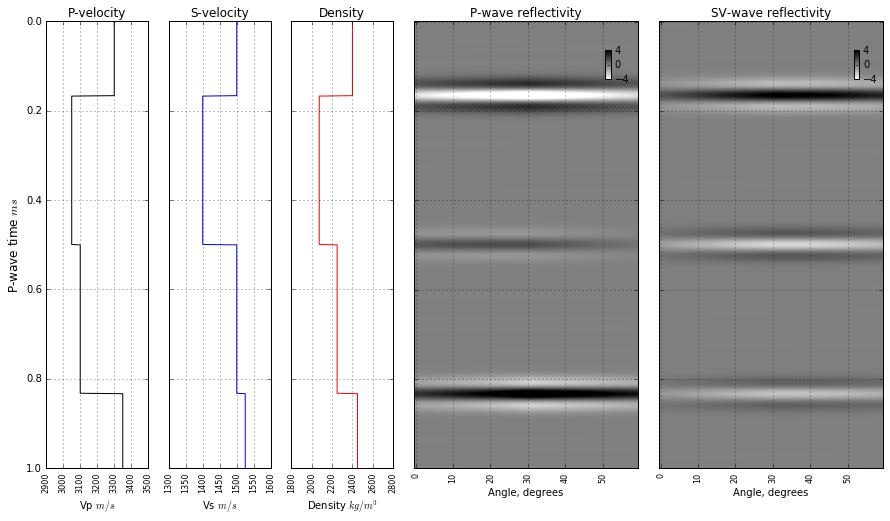

In [34]:
fs = 8  # fontsize for our axis labels
max_val = 4 # +/- max value for seismic amplitude display (clip)
 
# make a figure
fig = plt.figure(figsize=(15,8))

# create a grid of 5 axes panels, whereby the last two 
# are twice as wide as the rest (they will contain the AVO gather images)
gs = gridspec.GridSpec(1, 7)
ax1 = plt.subplot(gs[:, 0])   # Vp log
ax2 = plt.subplot(gs[:, 1])   # Vs log
ax3 = plt.subplot(gs[:, 2])   # Density log
ax4 = plt.subplot(gs[:, 3:5]) # PP AVO gather
ax5 = plt.subplot(gs[:, 5:])  # PS AVO gather

# Plot the Vp log
ax1.plot(vp, t, 'k', label='Vp')
ax1.set_title('P-velocity')
ax1.set_ylabel(r'P-wave time $ms$', size=12)
ax1.invert_yaxis()
ax1.set_xlim((2900,3500))
ax1.set_xlabel(r'Vp $m/s$')
ax1.grid()
labels = ax1.get_xticklabels() 
for label in labels: 
    label.set_rotation(90) 
    label.set_fontsize(fs)

# Plot the Vs log
ax2.plot(vs, t, 'b', label='Vp')
ax2.set_title('S-velocity')
ax2.invert_yaxis()
ax2.set_xlim((1300,1600))
ax2.set_yticklabels([])
ax2.set_xlabel(r'Vs $m/s$')
ax2.grid()
labels = ax2.get_xticklabels() 
for label in labels: 
    label.set_rotation(90) 
    label.set_fontsize(fs)

# Plot the density log
ax3.plot(rho, t, 'r', label='Vp')
ax3.set_title('Density')
ax3.invert_yaxis()
ax3.set_xlim((1800,2800))
ax3.set_yticklabels([])
ax3.set_xlabel(r'Density $kg/m^3$')
labels = ax3.get_xticklabels() 
ax3.grid()
for label in labels: 
    label.set_rotation(90) 
    label.set_fontsize(fs)
    
# Plot the PP reflectivities as an image
imPP = ax4.imshow(syn_pp, cmap='gray_r', clim=[-max_val,max_val], 
           #extent = [min(theta1),max(theta1),1.0,0], 
           aspect='auto', origin='upper')
ax4.set_title('P-wave reflectivity')
ax4.set_yticklabels([])
ax4.set_xlabel(r'Angle, degrees')
labels = ax4.get_xticklabels() 
ax4.grid()
for label in labels: 
    label.set_rotation(90) 
    label.set_fontsize(fs)
    
caxPP = fig.add_axes([0.6425,0.80,0.005,0.05])
cax1 = fig.colorbar(imPP,caxPP)
cax1.set_ticks([-max_val, 0, max_val]) 
    
# Plot the PS reflectivities as an image
imPS = ax5.imshow(syn_ps, cmap='gray_r', clim=[-max_val,max_val], 
           #extent = [min(theta1),max(theta1),1.0,0], 
           aspect='auto', origin='upper')
ax5.set_title('SV-wave reflectivity')
ax5.set_yticklabels([])
ax5.set_xlabel(r'Angle, degrees')
labels = ax5.get_xticklabels() 
ax5.grid()
for label in labels: 
    label.set_rotation(90) 
    label.set_fontsize(fs)
    
caxPS = fig.add_axes([0.8725,0.80,0.005,0.05])
cax1 = fig.colorbar(imPS,caxPS)
cax1.set_ticks([-max_val, 0, max_val]) 
    
plt.show()

#3. A simple well log example

To demonstrate how to create a synthetic seismic gather from a well log, we'll start by importing the <code>Well</code> module in Striplog, because it has a function for creating well objects and reading well log data (LAS files). 

In [15]:
from striplog import Well

ImportError: No module named 'legend'

The filename of the well log we want is <code>'P-132_synth.las'</code>. Make sure it is in the same directory as the notebook, or git the path to it.

In [16]:
fname = 'P-132_synth.las'
well = Well(fname)

NameError: name 'Well' is not defined

If you take a look at the data content, there are a number of -999.25 values representing sample points with no data. Instead of editing the logs (which is another job in itself), we can crop out the missing data zones by indexing only over the range of data without missing values.

In [15]:
first = 1232 #1532
last = 26000 #26000

In [16]:
z = well.data['DEPT'][first:last]
dt = well.data['Sonic_despiked'][first:last]
rho = well.data['RHOB_despiked'][first:last]
tt = well.data['two-waytime'][first:last]

Convert the measurements into SI units:

In [17]:
vpz =  1e6 / (3.28084 * dt)        # SI units
rhoz = 1000.0 * rho              # SI units 

This well doesn't have a Vs log, but we can fake one for illustration purposes using Castagna's equation Mudrock line

In [18]:
vsz = (vpz - 1360)/1.16

## Make plot of the logs

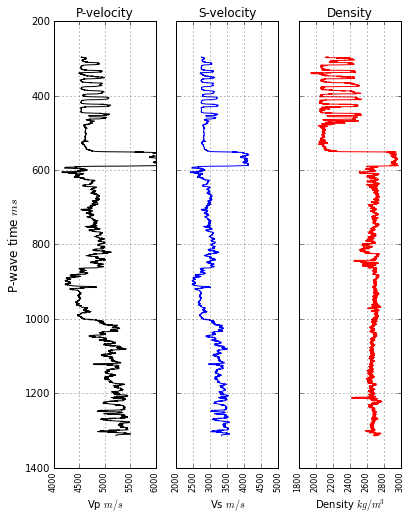

In [19]:
# make a figure of just the logs
fig = plt.figure(figsize=(15,8))

fs = 8  # control the fontsize
# create a grid of 5 axes panels, whereby the last two 
# are twice as wide as the rest (they will contain the AVO gather images)
gs = gridspec.GridSpec(1, 7)
ax1 = plt.subplot(gs[:, 0])   # Vp log
ax2 = plt.subplot(gs[:, 1])   # Vs log
ax3 = plt.subplot(gs[:, 2])   # Density log

# Plot the Vp log
ax1.plot(vpz, tt, 'k', label='Vp')
ax1.set_title('P-velocity')
ax1.set_ylabel(r'P-wave time $ms$', size=12)
ax1.invert_yaxis()
ax1.set_xlim((4000,6000))
ax1.set_xlabel(r'Vp $m/s$')
ax1.grid()
labels = ax1.get_xticklabels() 
for label in labels: 
    label.set_rotation(90) 
    label.set_fontsize(fs)

# Plot the Vs log
ax2.plot(vsz, tt, 'b', label='Vp')
ax2.set_title('S-velocity')
ax2.invert_yaxis()
ax2.set_xlim((2000,5000))
ax2.set_yticklabels([])
ax2.set_xlabel(r'Vs $m/s$')
ax2.grid()
labels = ax2.get_xticklabels() 
for label in labels: 
    label.set_rotation(90) 
    label.set_fontsize(fs)

# Plot the density log
ax3.plot(rhoz, tt, 'r', label='Vp')
ax3.set_title('Density')
ax3.invert_yaxis()
ax3.set_xlim((1800,3000))
ax3.set_yticklabels([])
ax3.set_xlabel(r'Density $kg/m^3$')
labels = ax3.get_xticklabels() 
ax3.grid()
for label in labels: 
    label.set_rotation(90) 
    label.set_fontsize(fs)

## Make the forward model

Same as in Part 2:

In [20]:
# travel time values from the log
x = tt

# 'Real' x values for model space — this is time so call it t
# we'll use the range from the first and last good values in log

t = np.arange(min(tt), max(tt), 1.0)

# Make interpolation function

def interp(x, y, x_new):
    f = scipy.interpolate.interp1d(x, y, kind='nearest')
    return f(x_new)

dvp, dvs, drho = [np.diff(interp(x, i, t)) for i in (vpz, vsz, rhoz)]

vpz, vsz, rhoz = [interp(x, i, t) for i in (vpz, vsz, rhoz)]

In [21]:
boundaries = np.abs(dvp) + np.abs(dvs) + np.abs(drho)  # Lazy catch-all

In [22]:
logs = zip(boundaries, vpz[:-1], vsz[:-1], rhoz[:-1], vpz[1:], vsz[1:], rhoz[1:])
Rpp, Rps = [], []
for boundary, vp1, vs1, rho1, vp0, vs0, rho0 in logs:
    if boundary:
        Rpp.append(zoeppritz_element(vp1, vs1, rho1, vp0, vs0, rho0, theta1, 'PdPu'))
        Rps.append(zoeppritz_element(vp1, vs1, rho1, vp0, vs0, rho0, theta1, 'PdSu'))
    else:
        Rpp.append(np.zeros(theta1.size))
        Rps.append(np.zeros(theta1.size))
Rppz = np.asarray(Rpp)
Rpsz = np.asarray(Rps)

## Make a wavelet

A 50 Hz ricker wavelet,

In [23]:
w = b.filters.ricker(duration=0.128, dt=0.001, f=25)
traces = theta1.size
w = np.tile(w, traces).reshape(traces, w.size).T

In [24]:
syn_pp = fftconvolve(Rppz, w, mode='same')
syn_ps = fftconvolve(Rpsz, w, mode='same')

In [25]:
fs = 8       # fontsize for our axis labels
max_val = 10.0 # +/- max value for seismic amplitude display (clip)

## Make a plot of the logs and the gathers

The final code block puts all the results into a single image consisting of 7 axes (tracks). It's rather long, because all the decoration and annotation has been done explicitly for clarity.

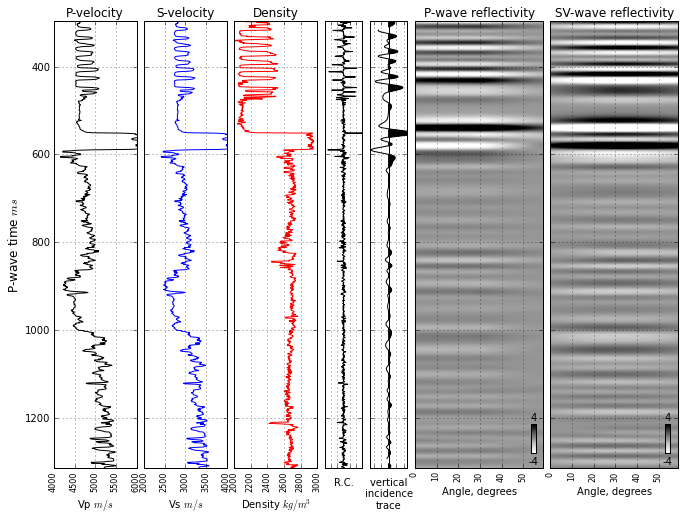

In [26]:
max_val = 4.0
trim = 20  # to remove edge effect at top and base of synthetics
# make a figure
fig = plt.figure(figsize=(12,8))

# create a grid of 5 axes panels, whereby the last two 
# are twice as wide as the rest (they will contain the AVO gather images)
gs = gridspec.GridSpec(1, 15)
ax1 = plt.subplot(gs[:, 1:3])   # Vp log
ax2 = plt.subplot(gs[:, 3:5])   # Vs log
ax3 = plt.subplot(gs[:, 5:7])   # Density log
ax4 = plt.subplot(gs[:, 7:8])   # R.C. series 
ax5 = plt.subplot(gs[:, 8:9])   # Zero-offset trace
ax6 = plt.subplot(gs[:, 9:12])  # PP AVO gather
ax7 = plt.subplot(gs[:, 12:15]) # PS AVO gather

# Plot the Vp log
ax1.plot(vpz, t, 'k')
ax1.set_title('P-velocity')
ax1.set_ylabel(r'P-wave time $ms$', size=12)
ax1.set_ylim((min(t),max(t)))
ax1.invert_yaxis()
ax1.set_xlim((4000,6000))
ax1.set_xlabel(r'Vp $m/s$')
ax1.grid()
labels = ax1.get_xticklabels() 
for label in labels: 
    label.set_rotation(90) 
    label.set_fontsize(fs)

# Plot the Vs log
ax2.plot(vsz, t, 'b')
ax2.set_title('S-velocity')
ax2.set_ylim((min(t),max(t)))
ax2.invert_yaxis()
ax2.set_xlim((2000,4000))
ax2.set_yticklabels([])
ax2.set_xlabel(r'Vs $m/s$')
ax2.grid()
labels = ax2.get_xticklabels() 
for label in labels: 
    label.set_rotation(90) 
    label.set_fontsize(fs)

# Plot the density log
ax3.plot(rhoz, t, 'r')
ax3.set_title('Density')
ax3.set_xlim((2000,3000))
ax3.set_ylim((min(t),max(t)))
ax3.invert_yaxis()
ax3.set_yticklabels([])
ax3.set_xlabel(r'Density $kg/m^3$')
labels = ax3.get_xticklabels() 
ax3.grid()
for label in labels: 
    label.set_rotation(90) 
    label.set_fontsize(fs)
   
# Plot the density log
ax4.plot(Rppz[:,0], t[1:], 'k')
ax4.set_xlim((-0.15,0.15))
ax4.set_ylim((min(t),max(t)))
ax4.invert_yaxis()
ax4.set_yticklabels([])
ax4.set_xticklabels([])
ax4.set_xlabel(r'R.C.')
labels = ax4.get_xticklabels() 
ax4.grid()
for label in labels: 
    label.set_rotation(90) 
    label.set_fontsize(fs)
    
# Plot the Zero offset Syn_pp trace 
ax5.plot(syn_pp[trim:-trim:,0], t[trim:-trim-1], 'k')
ax5.fill_betweenx(t[1:], syn_pp[:,0],  0, syn_pp[:,0] > 0.0,  color='k', alpha = 1.0)
ax5.axvline(x=0,c='k')
ax5.set_xlim((-5.0,5.0))
ax5.set_ylim((min(t),max(t)))
ax5.invert_yaxis()
ax5.set_yticklabels([])
ax5.set_xticklabels([])
ax5.set_xlabel('vertical \nincidence \ntrace')
labels = ax5.get_xticklabels() 
ax5.grid()
for label in labels: 
    label.set_rotation(90) 
    label.set_fontsize(fs)
    
# Plot the PP reflectivities as an image
imPP = ax6.imshow(syn_pp[trim:-trim:,:], cmap='Greys', clim=[-max_val,max_val], 
           extent = [min(theta1),max(theta1),max(t),min(t)], 
           aspect='auto', 
           origin='upper')
ax6.set_title('P-wave reflectivity')
ax6.set_yticklabels([])
ax6.set_xlabel(r'Angle, degrees')
labels = ax6.get_xticklabels() 
ax6.grid()
for label in labels: 
    label.set_rotation(90) 
    label.set_fontsize(fs)

caxPP = fig.add_axes([0.73,0.15,0.005,0.05])
cax1 = fig.colorbar(imPP, caxPP)
cax1.ax.text(0.5, 1.1, s=int(max_val), ha='center', va='bottom')
cax1.ax.text(0.5, -0.1, s=int(-1*max_val), ha='center', va='top')

cax1.set_ticks([]) 
    
# Plot the PS reflectivities as an image
imPS = ax7.imshow(syn_ps[trim:-trim:,:], cmap='Greys', clim=[-max_val,max_val], 
           extent = [min(theta1),max(theta1),max(t),min(t)], 
           aspect='auto', 
           origin='upper')
ax7.set_title('SV-wave reflectivity')
ax7.set_yticklabels([])
ax7.set_xlabel(r'Angle, degrees')
labels = ax7.get_xticklabels() 
ax7.grid()
for label in labels: 
    label.set_rotation(90) 
    label.set_fontsize(fs)

caxPS = fig.add_axes([0.885,0.15,0.005,0.05])
cax2 = fig.colorbar(imPS, caxPS)
cax2.ax.text(0.5, 1.1, s=int(max_val), ha='center', va='bottom')
cax2.ax.text(0.5, -0.1, s=int(-1*max_val), ha='center', va='top')
cax2.set_ticks([]) 
    
plt.show()

## Comparing traces

In [ ]:
Params

# frequency
f

# phase
phi

# of third event
dx

# amplitude of third event
a


In [154]:
import bruges as b
from scipy.signal import fftconvolve

In [155]:
#wvlts = [15, 18, 21, 24]

wvlt = b.filters.ricker(duration=0.128, dt=0.001, f=30)

traces = theta1.size

w = np.tile(wvlt, traces).reshape(traces, wvlt.size).T

syntAf = fftconvolve(Rpp, w, mode='same')

1.0
0.987795487473
0.836445280475
0.731317562262
0.433779323317


(-30, 6)

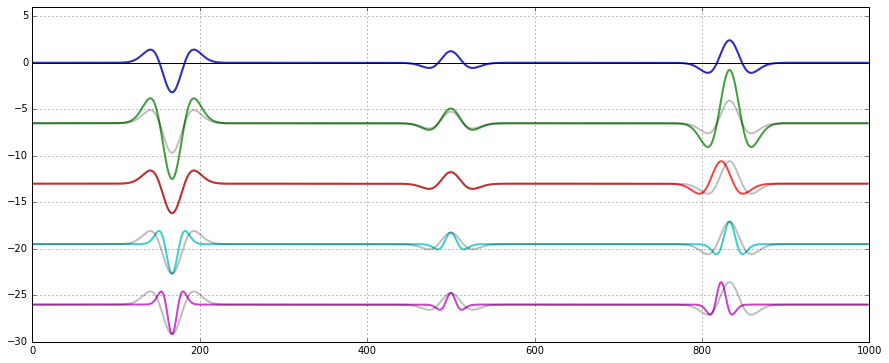

In [187]:
a, b = 0, 30
#tAf = syntAf[:,a]
#tA, tB, tAf = syn_pp[:,a], syn_pp[:,b], 

x, dx = 600, 10

tC = np.hstack((syn_pp[:x,a], syn_pp[x+dx:,a], np.zeros(dx)))
tCf = np.hstack((syntAf[:x,a], syntAf[x+dx:,a], np.zeros(dx)))


fig = plt.figure(figsize=(15,6))

wth = 6.5
traces = [tA, tB, tC, tAf, tCf]

for i, tr in enumerate([tA, tB, tC, tAf, tCf]):
    # avo trace, squeezed trace, different freq, diff freq squeeze
    print (np.corrcoef(tA,tr)[0][1])
    plt.plot(tr - i*wth , lw=2, alpha=0.75)
    plt.plot(tA - i*wth, 'k', lw=2, alpha=0.25)  # base trace
    plt.hlines(i*wth, xmin=0,xmax=len(tA))

plt.grid()
plt.ylim(-len(traces)*6, 6)


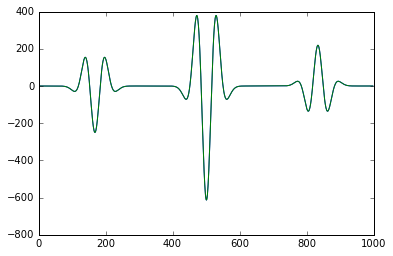

In [143]:
# xi = 600

for tr in [tB[xi:], tC[xi:]]:
    #print (np.correlate(tA, tr))
    np.convolve(tA, tr, mode='same')
    plt.plot(conv)

In [47]:
help(np.convolve)

Help on function convolve in module numpy.core.numeric:

convolve(a, v, mode='full')
    Returns the discrete, linear convolution of two one-dimensional sequences.
    
    The convolution operator is often seen in signal processing, where it
    models the effect of a linear time-invariant system on a signal [1]_.  In
    probability theory, the sum of two independent random variables is
    distributed according to the convolution of their individual
    distributions.
    
    If `v` is longer than `a`, the arrays are swapped before computation.
    
    Parameters
    ----------
    a : (N,) array_like
        First one-dimensional input array.
    v : (M,) array_like
        Second one-dimensional input array.
    mode : {'full', 'valid', 'same'}, optional
        'full':
          By default, mode is 'full'.  This returns the convolution
          at each point of overlap, with an output shape of (N+M-1,). At
          the end-points of the convolution, the signals do not overlap

In [44]:
conv

array([  6.70232257e-31,   1.81039657e-30,   3.30079135e-30, ...,
         2.37095981e-31,   1.70099759e-31,   1.42981214e-31])